# Exploratory Data Analysis - 2023 Telstra Optus Route Leak

## Incident 
TBW*

## What does this notebook implement ?

Unsupervised methos like SVM and Isolation Forests.

## Description of the Selected Features

The following features have been extracted from the BGP (Border Gateway Protocol) update messages contained in RIPE RIS MRT dumps and processed in configurable time windows:

1. **Feature 0: Total Number of BGP Update Messages**  
   - **Description**: The total count of all BGP update messages (both announcements and withdrawals) observed within each time window.  
   - **Use Case**: Provides a baseline measure of routing activity over time.  

2. **Feature 1: Number of BGP ANNOUNCEMENT Messages**  
   - **Description**: The total count of BGP `ANNOUNCEMENT` messages observed within each time window.  
   - **Use Case**: Tracks the frequency of new route announcements, indicating changes or additions in routing information.  

3. **Feature 2: Number of BGP WITHDRAWAL Messages**  
   - **Description**: The total count of BGP `WITHDRAWAL` messages observed within each time window.  
   - **Use Case**: Indicates how frequently routes are being removed or withdrawn, a potential indicator of network instability.  

4. **Feature 3: Average AS Path Length**  
   - **Description**: The average length of the Autonomous System (AS) path contained in BGP `ANNOUNCEMENT` messages for each time window.  
   - **Use Case**: Provides insights into routing path complexity and potential changes in routing policies.

5. **Feature 4: Median AS Path Length**  
   - **Description**: The median length of the Autonomous System (AS) path contained in BGP `ANNOUNCEMENT` messages for each time window.  
   - **Use Case**: A robust measure of central tendency for AS path lengths, less sensitive to outliers than the average.

6. **Feature 5: Number of Prefixes with AS Path Changes (Stable Origin AS)**  
   - **Description**: The count of prefixes where the AS path changes but the origin AS (last AS in the path) remains the same, observed within each time window.  
   - **Use Case**: Detects routing updates that modify paths without changing the origin, which could signal route optimization, policy changes, or anomalies.

## Plot Currently Identified Features

We load and consolidate the features we have identified. The consolidated features dataframe is saved in a separate CSV file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specify the incident ID (e.g., replace with the relevant identifier)
INCIDENT = "2023-telstra-optus-leak"  # Replace with the actual incident identifier
COLLECTOR = "rrc23" ## Singapore
WINDOW = "w06s"

# File path for the consolidated features CSV
file_path = f"../../features/{INCIDENT}/{WINDOW}/consolidated_features_{COLLECTOR}.csv"

# Load the consolidated features file into merged_df
merged_df = pd.read_csv(file_path)

# Ensure timestamp is parsed as a datetime object
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Define anomaly intervals to highlight (as datetime or numeric values)
# Set intervals one hour around the estimated start and one hour around the estimated end
eda_anomaly_intervals = [
    ("2023-11-08 13:36:00","2023-11-08 14:36:09"),
    ("2023-11-08 19:52:00","2023-11-08 20:52:09"),
]

eda_anomaly_intervals

[('2023-11-08 13:36:00', '2023-11-08 14:36:09'),
 ('2023-11-08 19:52:00', '2023-11-08 20:52:09')]

In [2]:
merged_df[ ["timestamp","f0_update_count","f1_announcement_count"] ].head()

,timestamp,f0_update_count,f1_announcement_count
0,2023-11-08 09:00:00,4867,4788
1,2023-11-08 09:00:06,5737,5639
2,2023-11-08 09:00:12,4639,4524
3,2023-11-08 09:00:18,3696,3601
4,2023-11-08 09:00:24,3338,2532


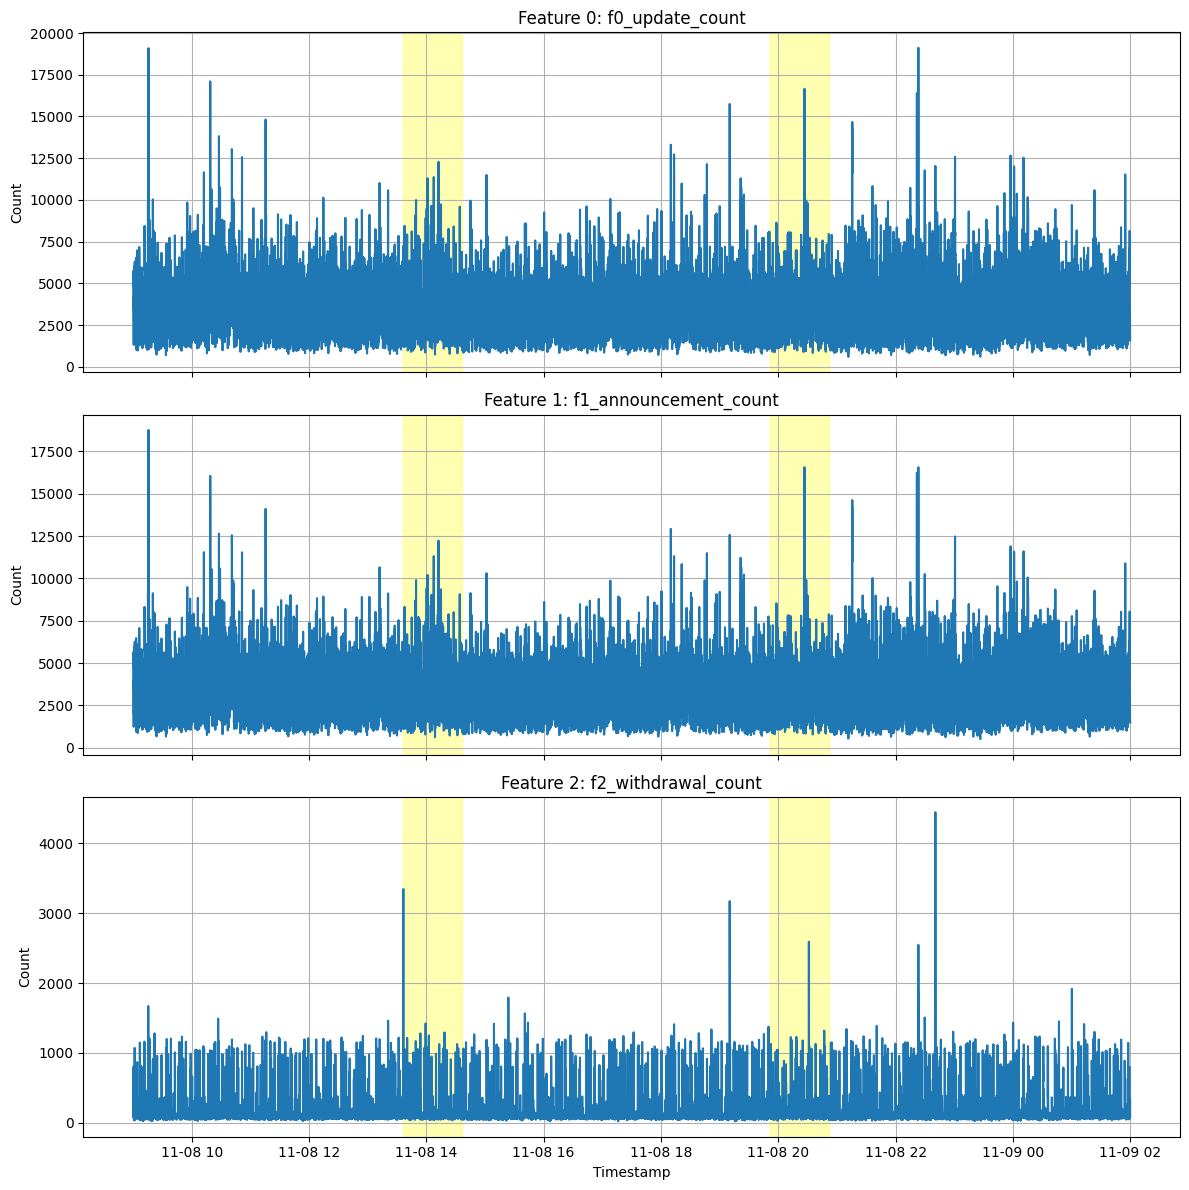

In [3]:
# Plotting
# fig, axs = plt.subplots(len(merged_df.columns) - 1, 1, figsize=(12, 12), sharex=True)
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot each feature dynamically and highlight anomaly intervals
for i, (col, ax) in enumerate(zip(merged_df.columns[1:], axs)):  # Skip 'timestamp'
    ax.plot(merged_df['timestamp'], merged_df[col])
    ax.set_title(f"Feature {i}: {col}")
    ax.set_ylabel("Count")
    ax.grid(True)
    
    # Add background highlights for anomalies
    for start, end in eda_anomaly_intervals:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='yellow', alpha=0.3)

# Add xlabel to the last subplot
axs[-1].set_xlabel("Timestamp")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Unsupervised model #1 - Isolation Forest

Detected anomalies:
                timestamp  f0_update_count  f1_announcement_count  \
17    2023-11-08 09:01:42             4788                   3716   
43    2023-11-08 09:04:18             6980                   6111   
70    2023-11-08 09:07:00             3430                   2282   
117   2023-11-08 09:11:42             6003                   4840   
118   2023-11-08 09:11:48             8443                   8320   
...                   ...              ...                    ...   
10149 2023-11-09 01:54:54            11530                  10896   
10179 2023-11-09 01:57:54             4735                   3590   
10184 2023-11-09 01:58:24             3490                   3410   
10191 2023-11-09 01:59:06             7081                   6281   
10194 2023-11-09 01:59:24             8145                   8049   

       f2_withdrawal_count  f3_avg_as_path_length  f4_median_as_path_length  \
17                    1071               4.654467                       

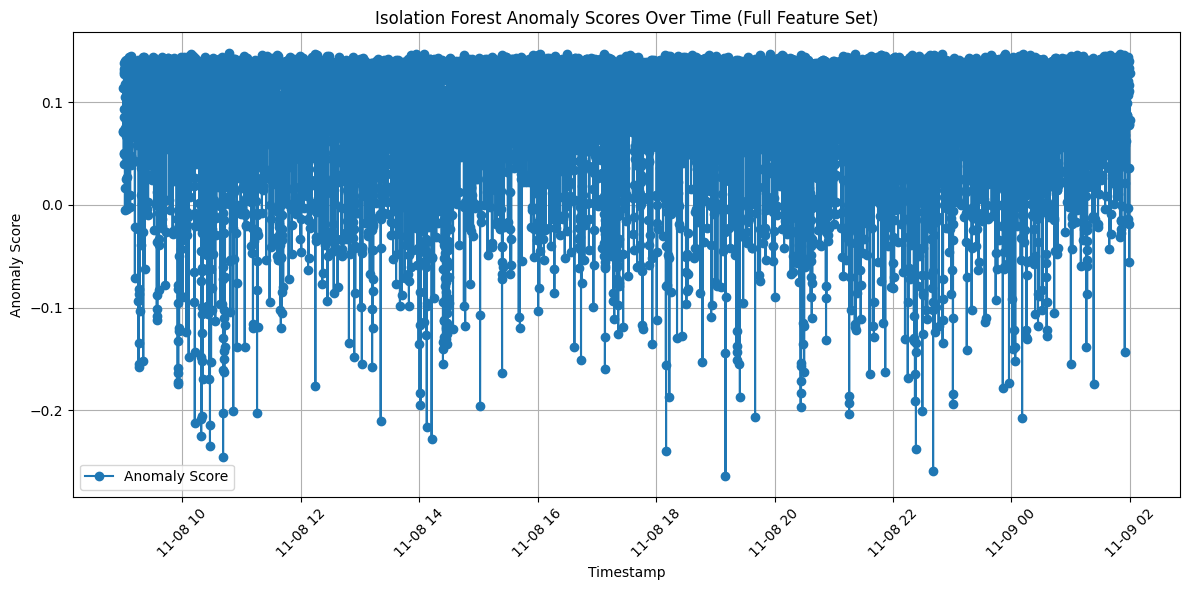

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# ---------------------------
# 1. Prepare the Data
# ---------------------------
# Ensure the timestamp column is in datetime format
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# ---------------------------
# 2. Define the Full Feature Set
# ---------------------------
features = [
    'f0_update_count',
    'f1_announcement_count',
    'f2_withdrawal_count',
    'f3_avg_as_path_length',
    'f4_median_as_path_length',
    'f5_as_path_change_count'
]

# ---------------------------
# 3. Initialize and Fit the Isolation Forest
# ---------------------------
# Set contamination to an estimate of the proportion of anomalies (adjust as needed)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(merged_df[features])

# ---------------------------
# 4. Predict Anomalies
# ---------------------------
# The predict method returns 1 for inliers (normal) and -1 for outliers (anomalies)
merged_df['anomaly'] = iso_forest.predict(merged_df[features])

# ---------------------------
# 5. Compute the Anomaly Scores
# ---------------------------
# The decision_function provides a continuous anomaly score (lower scores indicate anomalies)
merged_df['anomaly_score'] = iso_forest.decision_function(merged_df[features])

# Optionally, display the rows flagged as anomalies
anomalies = merged_df[merged_df['anomaly'] == -1]
print("Detected anomalies:")
print(anomalies[['timestamp'] + features])

# ---------------------------
# 6. Plot the Anomaly Scores Over Time
# ---------------------------
plt.figure(figsize=(12, 6))
plt.plot(merged_df['timestamp'], merged_df['anomaly_score'], marker='o', linestyle='-', label='Anomaly Score')
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.title("Isolation Forest Anomaly Scores Over Time (Full Feature Set)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Unsupervised Method #2 - One Class SVM

Apply a one class SVM model, calculate a decision score. Plot the decision score and visually identify a threshold which can the be used to produce a binary classification of normal / anomaly.

Detected anomalies:
                timestamp  f0_update_count  f1_announcement_count  \
0     2023-11-08 09:00:00             4867                   4788   
12    2023-11-08 09:01:12             3964                   3924   
17    2023-11-08 09:01:42             4788                   3716   
18    2023-11-08 09:01:48             6308                   6270   
29    2023-11-08 09:02:54             5519                   5080   
...                   ...              ...                    ...   
10106 2023-11-09 01:50:36             8361                   8028   
10121 2023-11-09 01:52:06             6909                   6817   
10149 2023-11-09 01:54:54            11530                  10896   
10179 2023-11-09 01:57:54             4735                   3590   
10194 2023-11-09 01:59:24             8145                   8049   

       f2_withdrawal_count  f3_avg_as_path_length  f4_median_as_path_length  \
0                       79               4.883250                       

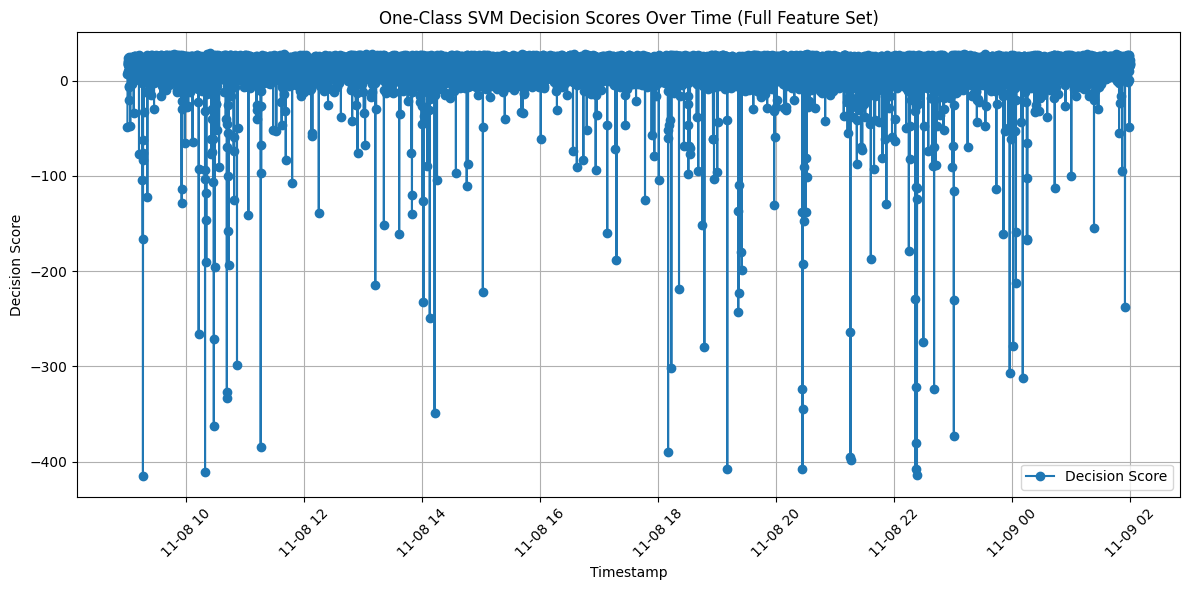

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM

# ---------------------------
# 1. Prepare the Data
# ---------------------------
# Ensure the timestamp column is in datetime format
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# ---------------------------
# 2. Define the Full Feature Set
# ---------------------------
features = [
    'f0_update_count',
    'f1_announcement_count',
    'f2_withdrawal_count',
    'f3_avg_as_path_length',
    'f4_median_as_path_length',
    'f5_as_path_change_count'
]

# Extract the features for modeling
X = merged_df[features]

# ---------------------------
# 3. Create and Train the One-Class SVM Model
# ---------------------------
# nu: Upper bound on the fraction of training errors, which also serves as a lower bound on the fraction of support vectors.
# kernel: Using 'rbf' for non-linear decision boundary; gamma is set to 'scale' by default.
oc_svm = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale', tol=0.001)
oc_svm.fit(X)

# ---------------------------
# 4. Predict Anomalies
# ---------------------------
# The model returns 1 for normal observations and -1 for anomalies.
predictions = oc_svm.predict(X)
merged_df['anomaly'] = predictions

# ---------------------------
# 5. Compute the Decision Scores
# ---------------------------
# The decision_function returns a continuous score; lower values indicate more abnormal observations.
merged_df['decision_score'] = oc_svm.decision_function(X)

# Optionally, display the detected anomalies
anomalies = merged_df[merged_df['anomaly'] == -1]
print("Detected anomalies:")
print(anomalies[['timestamp'] + features])

# ---------------------------
# 6. Plot the Decision Scores Over Time
# ---------------------------
plt.figure(figsize=(12, 6))
plt.plot(merged_df['timestamp'], merged_df['decision_score'], marker='o', linestyle='-', label='Decision Score')
plt.xlabel("Timestamp")
plt.ylabel("Decision Score")
plt.title("One-Class SVM Decision Scores Over Time (Full Feature Set)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Anomaly detection based on the decision score

Anomaly intervals based on decision score threshold:
From 2023-11-08 09:00:00 to 2023-11-08 09:00:06
From 2023-11-08 09:01:48 to 2023-11-08 09:01:54
From 2023-11-08 09:02:54 to 2023-11-08 09:03:00
From 2023-11-08 09:06:24 to 2023-11-08 09:06:30
From 2023-11-08 09:11:48 to 2023-11-08 09:11:54
From 2023-11-08 09:15:18 to 2023-11-08 09:15:42
From 2023-11-08 09:15:48 to 2023-11-08 09:16:00
From 2023-11-08 09:16:48 to 2023-11-08 09:16:54
From 2023-11-08 09:20:18 to 2023-11-08 09:20:24
From 2023-11-08 09:27:06 to 2023-11-08 09:27:12
From 2023-11-08 09:55:06 to 2023-11-08 09:55:18
From 2023-11-08 09:55:24 to 2023-11-08 09:55:36
....
Number of anomaly intervals: 246


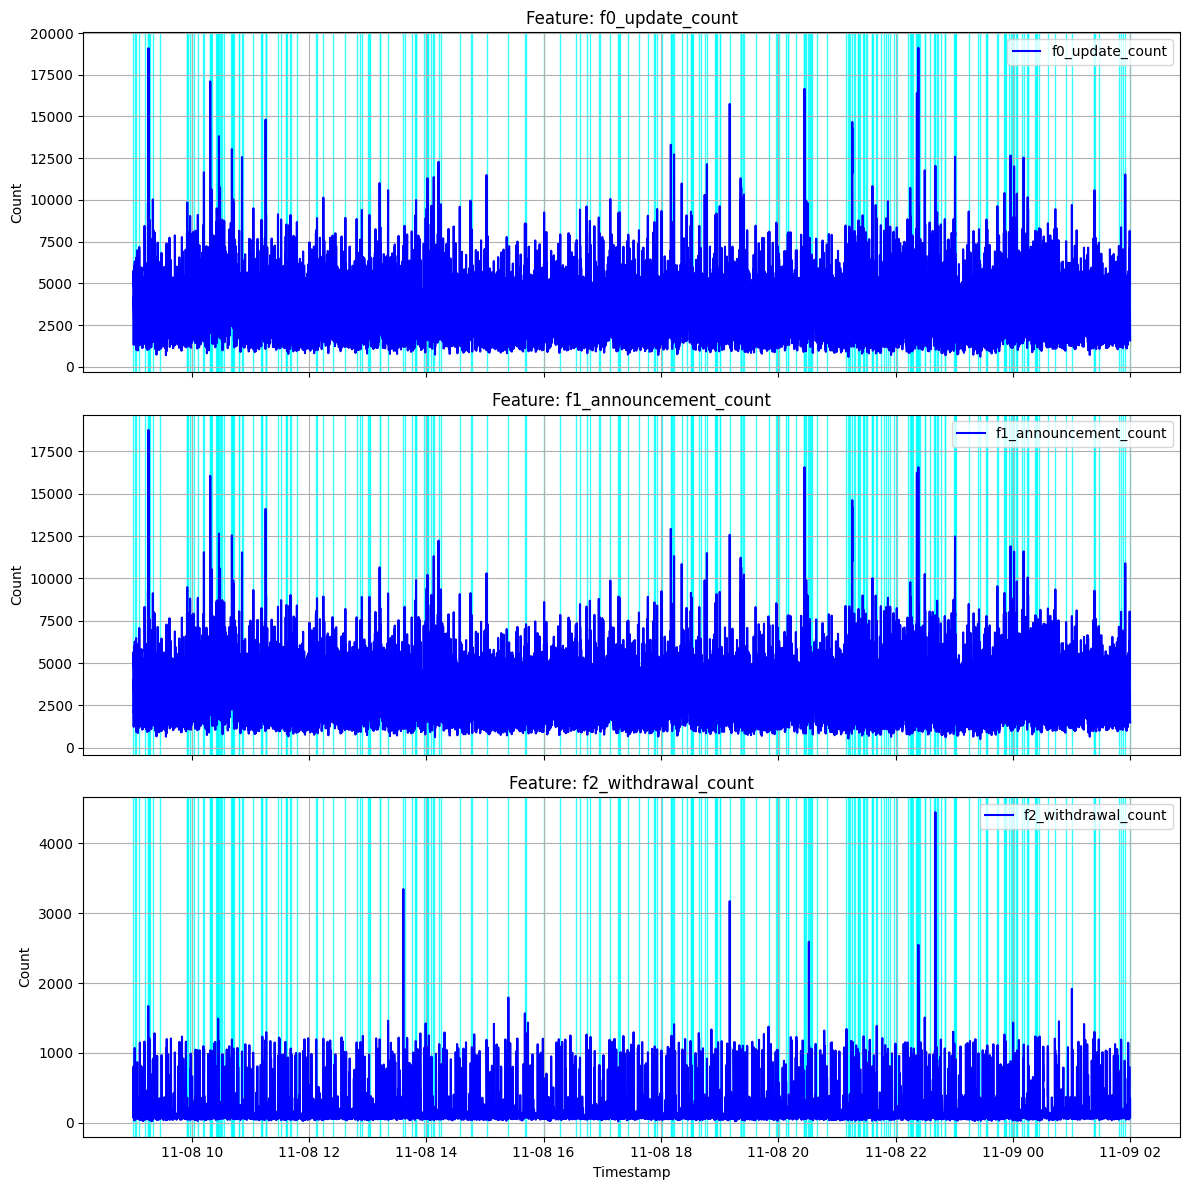

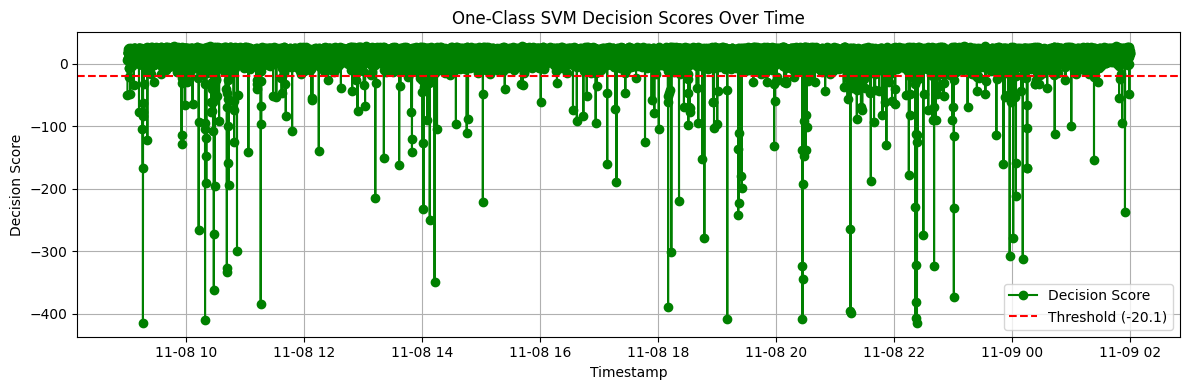

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper Function ---
def compute_anomaly_intervals_from_score(df, score_col='decision_score', threshold=-0.1, time_col='timestamp'):
    """
    Compute contiguous intervals where the decision score is below the given threshold.
    
    Parameters:
        df (DataFrame): The data frame, assumed to be sorted by time.
        score_col (str): Column name for decision scores.
        threshold (float): The threshold below which points are considered anomalous.
        time_col (str): Column name for time stamps.
        
    Returns:
        intervals (list): List of (start, end) tuples of anomaly intervals.
    """
    intervals = []
    in_interval = False
    start = None

    for i, row in df.iterrows():
        if row[score_col] < threshold and not in_interval:
            # Starting a new anomaly interval.
            in_interval = True
            start = row[time_col]
        elif row[score_col] >= threshold and in_interval:
            # Ending the current anomaly interval.
            end = row[time_col]
            intervals.append((start, end))
            in_interval = False

    # If an anomaly interval continues until the end of the DataFrame
    if in_interval:
        end = df.iloc[-1][time_col]
        intervals.append((start, end))
        
    return intervals

# --- Assume merged_df already exists and contains the following columns ---
# 'timestamp', 'f0_update_count', 'f1_announcement_count', 'f2_withdrawal_count',
# 'f3_avg_as_path_length', 'f4_median_as_path_length', 'f5_as_path_change_count',
# and 'decision_score' computed from One-Class SVM.
#
# Make sure the DataFrame is sorted by timestamp:
merged_df = merged_df.sort_values(by='timestamp')

#######################################################################################
#######################################################################################
# --- Define the threshold ---
# Adjust this threshold as needed based on the distribution of your decision scores.
score_threshold = -20.1
#######################################################################################
#######################################################################################

# Compute anomaly intervals using the decision score threshold.
anomaly_intervals = compute_anomaly_intervals_from_score(merged_df, score_col='decision_score',
                                                         threshold=score_threshold, time_col='timestamp')

print("Anomaly intervals based on decision score threshold:")
nnn = 0
for start, end in anomaly_intervals:
    nnn = nnn + 1
    if nnn <= 12:
        print(f"From {start} to {end}")
    else:
        print("....")
        break
print(f"Number of anomaly intervals: {len(anomaly_intervals)}")

# --- Plot 1: Actual Data Features with Highlighted Anomaly Intervals ---
# Choose the features you want to plot; here we plot 3 example features.
features_to_plot = ['f0_update_count', 'f1_announcement_count', 'f2_withdrawal_count']

fig, axs = plt.subplots(len(features_to_plot), 1, figsize=(12, 12), sharex=True)

for i, (col, ax) in enumerate(zip(features_to_plot, axs)):
    ax.plot(merged_df['timestamp'], merged_df[col], label=col, color='blue')
    ax.set_title(f"Feature: {col}")
    ax.set_ylabel("Count")
    ax.grid(True)
    
    # Highlight anomaly intervals (where decision_score < threshold)
    for start, end in anomaly_intervals:
        ax.axvspan(start, end, color='cyan', alpha=0.8)
        
    # Add legend if not already added.
    ax.legend()

axs[-1].set_xlabel("Timestamp")
plt.tight_layout()
plt.show()

# --- Plot 2: Decision Scores with Threshold ---
plt.figure(figsize=(12, 4))
plt.plot(merged_df['timestamp'], merged_df['decision_score'], marker='o', linestyle='-', color='green', label='Decision Score')
plt.axhline(y=score_threshold, color='red', linestyle='--', label=f"Threshold ({score_threshold})")
plt.title("One-Class SVM Decision Scores Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Decision Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Unsupervised 3 : 1-Class SVM with anomaly interval clustering

First few anomaly intervals:
                start                 end
0 2023-11-08 09:00:00 2023-11-08 09:00:06
1 2023-11-08 09:02:54 2023-11-08 09:03:00
2 2023-11-08 09:06:24 2023-11-08 09:06:30
3 2023-11-08 09:11:48 2023-11-08 09:11:54
4 2023-11-08 09:15:18 2023-11-08 09:15:42

First few merged anomaly intervals:
                start                 end
0 2023-11-08 09:00:00 2023-11-08 09:06:30
1 2023-11-08 09:11:48 2023-11-08 09:20:24
2 2023-11-08 09:55:06 2023-11-08 09:58:30
3 2023-11-08 10:06:18 2023-11-08 10:06:24
4 2023-11-08 10:12:30 2023-11-08 10:12:42


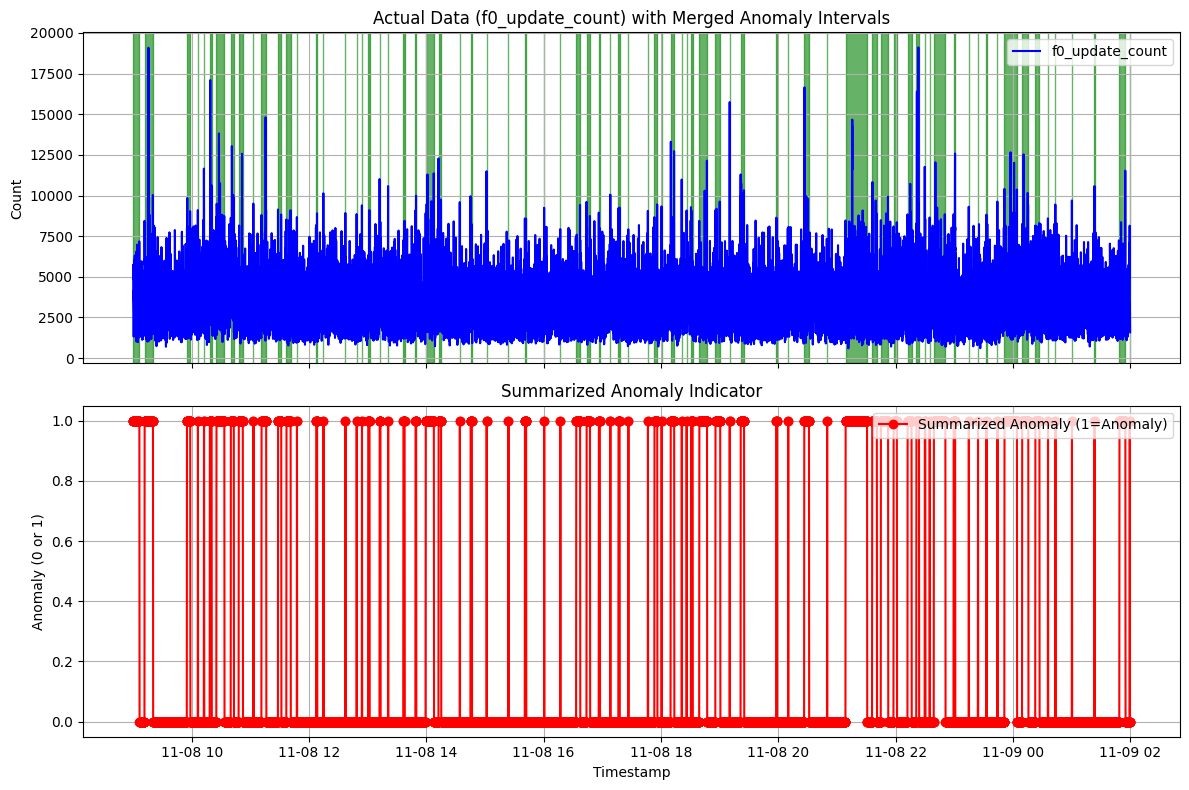

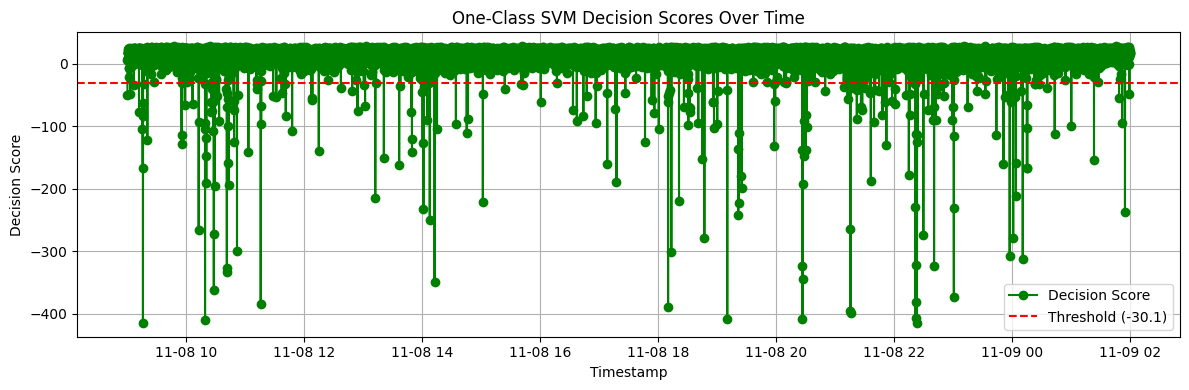

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Compute anomaly intervals using the decision score threshold ---
def compute_anomaly_intervals_from_score(df, score_col='decision_score', threshold=-0.1, time_col='timestamp'):
    """
    Compute contiguous intervals where the decision score is below the given threshold.
    
    Parameters:
        df (DataFrame): The data frame, assumed to be sorted by time.
        score_col (str): Column name for decision scores.
        threshold (float): The threshold below which points are considered anomalous.
        time_col (str): Column name for time stamps.
        
    Returns:
        intervals (list of tuples): List of (start, end) tuples of anomaly intervals.
    """
    intervals = []
    in_interval = False
    start = None

    for i, row in df.iterrows():
        if row[score_col] < threshold and not in_interval:
            # Starting a new anomaly interval.
            in_interval = True
            start = row[time_col]
        elif row[score_col] >= threshold and in_interval:
            # Ending the current anomaly interval.
            end = row[time_col]
            intervals.append((start, end))
            in_interval = False

    # If an anomaly interval continues until the end of the DataFrame, close it.
    if in_interval:
        end = df.iloc[-1][time_col]
        intervals.append((start, end))
        
    return intervals

# --- Step 2: Merge intervals that are close together ---
def merge_intervals(intervals, gap_threshold=pd.Timedelta(seconds=60)):
    """
    Merge intervals that are separated by less than the specified gap_threshold.
    
    Parameters:
        intervals (list of tuples): Each tuple is (start, end) (both pandas Timestamps).
        gap_threshold (Timedelta): Maximum gap between intervals to merge them.
    
    Returns:
        merged_intervals (list of tuples): Merged (start, end) intervals.
    """
    if not intervals:
        return []
    
    # Sort intervals by start time
    intervals = sorted(intervals, key=lambda x: x[0])
    merged = [intervals[0]]
    
    for current in intervals[1:]:
        last_start, last_end = merged[-1]
        # If the gap between the last interval's end and the current interval's start is small enough, merge them.
        if current[0] - last_end <= gap_threshold:
            merged[-1] = (last_start, max(last_end, current[1]))
        else:
            merged.append(current)
    
    return merged

# --- Assume merged_df already exists and contains:
# 'timestamp', 'f0_update_count', 'f1_announcement_count', 'f2_withdrawal_count',
# 'f3_avg_as_path_length', 'f4_median_as_path_length', 'f5_as_path_change_count',
# and 'decision_score' computed from the One-Class SVM.
# Ensure the DataFrame is sorted by timestamp:
merged_df = merged_df.sort_values(by='timestamp')

#######################################################################################
#######################################################################################
# Set your decision score threshold (adjust as needed)
score_threshold = -30.1
#######################################################################################
#######################################################################################

# Compute initial anomaly intervals based on the decision scores.
anomaly_intervals = compute_anomaly_intervals_from_score(merged_df, score_col='decision_score',
                                                         threshold=score_threshold, time_col='timestamp')

# Convert the list of anomaly intervals to a DataFrame for better visualization.
df_anomaly_intervals = pd.DataFrame(anomaly_intervals, columns=['start', 'end'])
print("First few anomaly intervals:")
print(df_anomaly_intervals.head())

# Merge intervals that are close together (e.g., if gaps are less than 60 seconds)
gap_threshold = pd.Timedelta(seconds=240)
merged_anomaly_intervals = merge_intervals(anomaly_intervals, gap_threshold)

# Convert the merged anomaly intervals to a DataFrame.
df_merged_intervals = pd.DataFrame(merged_anomaly_intervals, columns=['start', 'end'])
print("\nFirst few merged anomaly intervals:")
print(df_merged_intervals.head())

# --- Step 3: Create a Binary Indicator for Summarized Anomaly Intervals ---
def in_any_interval(ts, intervals):
    """Return True if ts is within any (start, end) tuple in intervals."""
    return any(start <= ts <= end for start, end in intervals)

merged_df['summarized_anomaly'] = merged_df['timestamp'].apply(
    lambda ts: 1 if in_any_interval(ts, merged_anomaly_intervals) else 0
)

# --- Step 4: Plot the Actual Data with Summarized Anomaly Intervals ---
# For demonstration, we'll use 'f0_update_count' as the representative feature.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top Panel: Actual data with merged anomaly intervals highlighted.
ax1.plot(merged_df['timestamp'], merged_df['f0_update_count'], label='f0_update_count', color='blue')
for start, end in merged_anomaly_intervals:
    ax1.axvspan(start, end, color='green', alpha=0.6)
ax1.set_title("Actual Data (f0_update_count) with Merged Anomaly Intervals")
ax1.set_ylabel("Count")
ax1.legend(loc='upper right')
ax1.grid(True)

# Bottom Panel: Binary indicator of summarized anomaly intervals.
ax2.plot(merged_df['timestamp'], merged_df['summarized_anomaly'], label='Summarized Anomaly (1=Anomaly)', 
         color='red', marker='o', linestyle='-')
ax2.set_title("Summarized Anomaly Indicator")
ax2.set_ylabel("Anomaly (0 or 1)")
ax2.set_xlabel("Timestamp")
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

# --- (Optional) Plot the Decision Scores with the Threshold ---
plt.figure(figsize=(12, 4))
plt.plot(merged_df['timestamp'], merged_df['decision_score'], marker='o', linestyle='-', color='green', label='Decision Score')
plt.axhline(y=score_threshold, color='red', linestyle='--', label=f"Threshold ({score_threshold})")
plt.title("One-Class SVM Decision Scores Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Decision Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Comparison with the summarized intervals

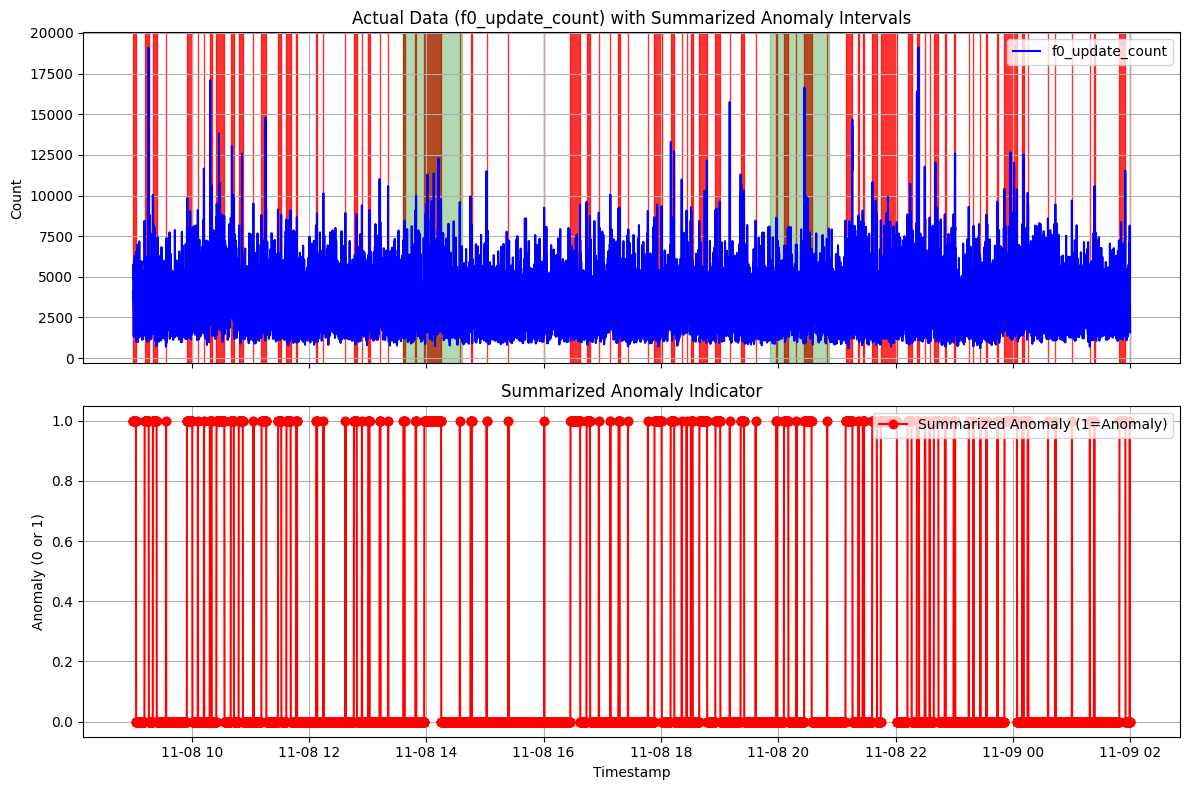

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Create a Binary Indicator for Summarized Anomaly Intervals ---
def in_any_interval(ts, intervals):
    """Return True if ts is within any (start, end) tuple in intervals."""
    return any(start <= ts <= end for start, end in intervals)

# Create a binary column where 1 indicates the timestamp falls in a merged anomaly interval.
merged_df['summarized_anomaly'] = merged_df['timestamp'].apply(
    lambda ts: 1 if in_any_interval(ts, merged_anomaly_intervals) else 0
)

# --- Step 2: Create a Comparison Plot ---
# For demonstration, we'll use 'f0_update_count' as the representative feature.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top Panel: Actual data with shaded merged anomaly intervals.
ax1.plot(merged_df['timestamp'], merged_df['f0_update_count'], label='f0_update_count', color='blue')
for start, end in merged_anomaly_intervals:
    ax1.axvspan(start, end, color='red', alpha=0.8)

# Add background highlights for anomalies
for start, end in eda_anomaly_intervals:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='green', alpha=0.3)    

ax1.set_title("Actual Data (f0_update_count) with Summarized Anomaly Intervals")
ax1.set_ylabel("Count")
ax1.legend(loc='upper right')
ax1.grid(True)

# Bottom Panel: Binary indicator of summarized anomaly intervals.
ax2.plot(merged_df['timestamp'], merged_df['summarized_anomaly'], label='Summarized Anomaly (1=Anomaly)', 
         color='red', marker='o', linestyle='-')
ax2.set_title("Summarized Anomaly Indicator")
ax2.set_ylabel("Anomaly (0 or 1)")
ax2.set_xlabel("Timestamp")
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [9]:
df_merged_intervals

,start,end
0,2023-11-08 09:00:00,2023-11-08 09:06:30
1,2023-11-08 09:11:48,2023-11-08 09:20:24
2,2023-11-08 09:55:06,2023-11-08 09:58:30
3,2023-11-08 10:06:18,2023-11-08 10:06:24
4,2023-11-08 10:12:30,2023-11-08 10:12:42
...,...,...
72,2023-11-09 00:43:24,2023-11-09 00:43:30
73,2023-11-09 01:00:18,2023-11-09 01:00:24
74,2023-11-09 01:23:24,2023-11-09 01:23:30
75,2023-11-09 01:48:54,2023-11-09 01:55:00


## Unsupervised 3 - LoF Local Outlier Factor

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

#######################################################################################
#######################################################################################
# Choose a LOF threshold (e.g., -1.5; adjust as needed)
lof_threshold = -2.4
#######################################################################################
#######################################################################################

First few raw anomaly intervals based on LOF:
                start                 end
0 2023-11-08 09:15:36 2023-11-08 09:15:42
1 2023-11-08 09:15:48 2023-11-08 09:15:54
2 2023-11-08 09:20:18 2023-11-08 09:20:24
3 2023-11-08 10:12:30 2023-11-08 10:12:36
4 2023-11-08 10:19:00 2023-11-08 10:19:06

First few merged anomaly intervals based on LOF:
                start                 end
0 2023-11-08 09:15:36 2023-11-08 09:15:54
1 2023-11-08 09:20:18 2023-11-08 09:20:24
2 2023-11-08 10:12:30 2023-11-08 10:12:36
3 2023-11-08 10:19:00 2023-11-08 10:20:24
4 2023-11-08 10:27:48 2023-11-08 10:29:06


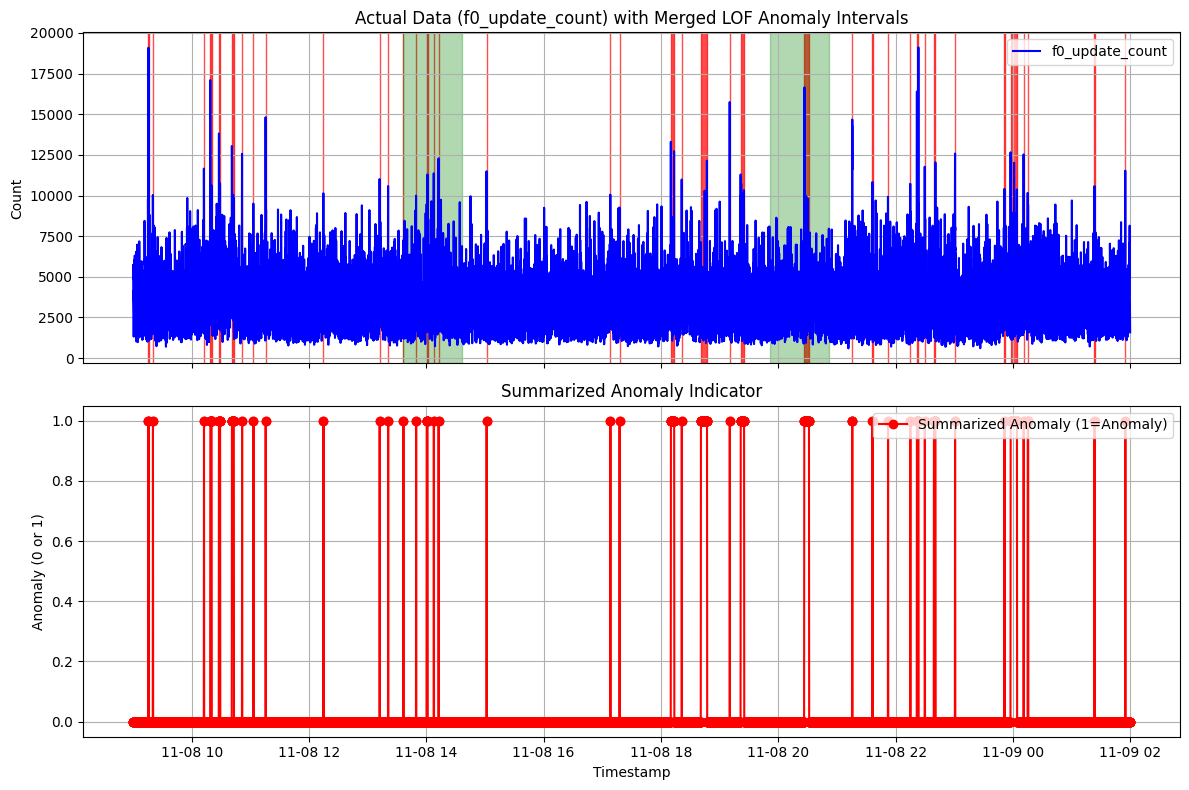

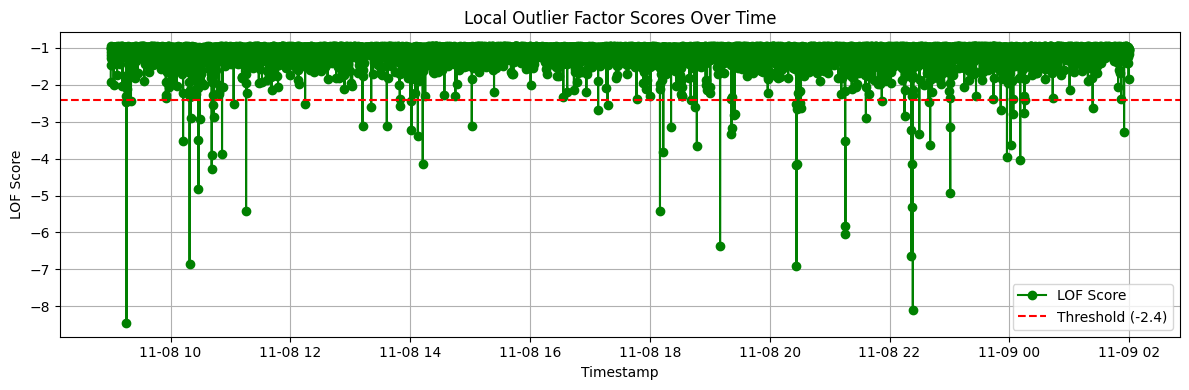

In [22]:
# ---------------------------
# Step 1: Prepare Data and Compute LOF Scores
# ---------------------------
# Ensure the 'timestamp' column is in datetime format and sort by time
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
merged_df = merged_df.sort_values(by='timestamp')

# Define the full set of features
features = [
    'f0_update_count',
    'f1_announcement_count',
    'f2_withdrawal_count',
    'f3_avg_as_path_length',
    'f4_median_as_path_length',
    'f5_as_path_change_count'
]
X = merged_df[features]

# Initialize and fit the LOF model.
# Note: LOF does not support novelty detection (novelty=False by default),
# so we use fit_predict on the entire dataset.
lof = LocalOutlierFactor(n_neighbors=1200, contamination=0.1)
predictions = lof.fit_predict(X)

# LOF returns a negative outlier factor: lower (more negative) values indicate more abnormal points.
merged_df['lof_score'] = lof.negative_outlier_factor_
merged_df['lof_pred'] = predictions  # -1 indicates outlier, 1 indicates inlier

# ---------------------------
# Step 2: Compute Anomaly Intervals Based on LOF Score
# ---------------------------
def compute_anomaly_intervals_from_score(df, score_col='lof_score', threshold=-1.5, time_col='timestamp'):
    """
    Compute contiguous intervals where the LOF score is below a given threshold.
    
    Parameters:
        df (DataFrame): Data sorted by time.
        score_col (str): Column name for LOF scores.
        threshold (float): LOF score threshold. Points with score < threshold are anomalous.
        time_col (str): Column name for timestamps.
        
    Returns:
        intervals (list of tuples): Each tuple is (start, end) timestamp.
    """
    intervals = []
    in_interval = False
    start = None

    for i, row in df.iterrows():
        if row[score_col] < threshold and not in_interval:
            # Start a new interval.
            in_interval = True
            start = row[time_col]
        elif row[score_col] >= threshold and in_interval:
            # End the current interval.
            end = row[time_col]
            intervals.append((start, end))
            in_interval = False

    # If still in an interval at the end, close it.
    if in_interval:
        end = df.iloc[-1][time_col]
        intervals.append((start, end))
        
    return intervals

anomaly_intervals = compute_anomaly_intervals_from_score(merged_df, score_col='lof_score', 
                                                         threshold=lof_threshold, time_col='timestamp')

# Convert the list of raw anomaly intervals to a DataFrame for inspection
df_anomaly_intervals = pd.DataFrame(anomaly_intervals, columns=['start', 'end'])
print("First few raw anomaly intervals based on LOF:")
print(df_anomaly_intervals.head())

# ---------------------------
# Step 3: Merge Intervals That Are Close Together
# ---------------------------
def merge_intervals(intervals, gap_threshold=pd.Timedelta(seconds=60)):
    """
    Merge intervals if the gap between the end of the previous interval and 
    the start of the next is less than gap_threshold.
    
    For two intervals A=(start_A, end_A) and B=(start_B, end_B):
      If (start_B - end_A) < gap_threshold, merge them into (start_A, max(end_A, end_B)).
    
    Parameters:
        intervals (list of tuples): Each tuple is (start, end) as pandas Timestamps.
        gap_threshold (Timedelta): Maximum allowed gap to merge intervals.
    
    Returns:
        merged_intervals (list of tuples): Merged intervals.
    """
    if not intervals:
        return []
    
    # Sort intervals by start time.
    intervals = sorted(intervals, key=lambda x: x[0])
    merged = [intervals[0]]
    
    for current in intervals[1:]:
        last_start, last_end = merged[-1]
        current_start, current_end = current
        # If the gap between last_end and current_start is less than the threshold, merge.
        if (current_start - last_end) < gap_threshold:
            # According to your idea, the merged interval starts at last_start and ends at current_end.
            # However, to be safe in case of overlapping intervals, we take the maximum end.
            merged[-1] = (last_start, max(last_end, current_end))
        else:
            merged.append(current)
    return merged

# Merge intervals with a gap threshold of 60 seconds.
gap_threshold = pd.Timedelta(seconds=240)
merged_anomaly_intervals_1 = merge_intervals(anomaly_intervals, gap_threshold) 
merged_anomaly_intervals = merge_intervals(merged_anomaly_intervals_1, gap_threshold) 

# Convert merged intervals to a DataFrame.
df_merged_intervals = pd.DataFrame(merged_anomaly_intervals, columns=['start', 'end'])
print("\nFirst few merged anomaly intervals based on LOF:")
print(df_merged_intervals.head())

# ---------------------------
# Step 4: Create a Binary Indicator for the Merged Anomaly Intervals
# ---------------------------
def in_any_interval(ts, intervals):
    """Return True if timestamp ts is within any of the (start, end) intervals."""
    return any(start <= ts <= end for start, end in intervals)

merged_df['summarized_anomaly'] = merged_df['timestamp'].apply(
    lambda ts: 1 if in_any_interval(ts, merged_anomaly_intervals) else 0
)

# ---------------------------
# Step 5: Plot the Data with the Summarized Anomaly Intervals
# ---------------------------
# (A) Plot a representative feature (e.g., 'f0_update_count') with merged anomaly intervals.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(merged_df['timestamp'], merged_df['f0_update_count'], label='f0_update_count', color='blue')
for start, end in merged_anomaly_intervals:
    ax1.axvspan(start, end, color='red', alpha=0.7)
# Add background highlights for anomalies
for start, end in eda_anomaly_intervals:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='green', alpha=0.3)      
ax1.set_title("Actual Data (f0_update_count) with Merged LOF Anomaly Intervals")
ax1.set_ylabel("Count")
ax1.legend(loc='upper right')
ax1.grid(True)

# (B) Plot the binary indicator of summarized anomaly intervals.
ax2.plot(merged_df['timestamp'], merged_df['summarized_anomaly'], label='Summarized Anomaly (1=Anomaly)', 
         color='red', marker='o', linestyle='-')
ax2.set_title("Summarized Anomaly Indicator")
ax2.set_ylabel("Anomaly (0 or 1)")
ax2.set_xlabel("Timestamp")
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

# ---------------------------
# Step 6: Plot the LOF Scores with the Threshold for Comparison
# ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(merged_df['timestamp'], merged_df['lof_score'], marker='o', linestyle='-', color='green', label='LOF Score')
plt.axhline(y=lof_threshold, color='red', linestyle='--', label=f"Threshold ({lof_threshold})")
plt.title("Local Outlier Factor Scores Over Time")
plt.xlabel("Timestamp")
plt.ylabel("LOF Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
df_merged_intervals.head(20)

,start,end
0,2023-11-08 09:15:36,2023-11-08 09:15:54
1,2023-11-08 09:20:18,2023-11-08 09:20:24
2,2023-11-08 10:12:30,2023-11-08 10:12:36
3,2023-11-08 10:19:00,2023-11-08 10:20:24
4,2023-11-08 10:27:48,2023-11-08 10:29:06
5,2023-11-08 10:41:06,2023-11-08 10:43:06
6,2023-11-08 10:51:30,2023-11-08 10:51:36
7,2023-11-08 11:03:06,2023-11-08 11:03:12
8,2023-11-08 11:15:36,2023-11-08 11:15:42
9,2023-11-08 12:14:42,2023-11-08 12:14:48


In [24]:
df_anomaly_intervals.describe()

,start,end
count,63,63
mean,2023-11-08 17:41:12.952380672,2023-11-08 17:41:19.809523456
min,2023-11-08 09:15:36,2023-11-08 09:15:42
25%,2023-11-08 13:16:33,2023-11-08 13:16:39
50%,2023-11-08 18:47:00,2023-11-08 18:47:06
75%,2023-11-08 22:22:00,2023-11-08 22:22:09
max,2023-11-09 01:54:54,2023-11-09 01:55:00
